<a href="https://colab.research.google.com/github/Vineetha8193/Breast-Cancer-Prediction-uisng-Machine-Learning/blob/main/Copy_of_Breast_Cancer_Diagnostics_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-cancer-wisconsin:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F563570%2F1085908%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T173148Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dd2d807e42c8b695410c3b3c4bc34215bd51887ca9bafa4e9dc16728c541d0d87e3b9b559ba0928354f59c87239df306394cc4ccb453358d65d6043f84fd464acd6681bcfe8c0bb1b078ce261d5448f1b884595b47a6f009444f52984f08a7215f694c8d0317ac5bc371d25545923a3715ba86dc5d6b30dce6a949a3d0e464e4a27f9dba310368e55c5e07ea35295f613831714f0fd01bef866253273f1a444f39c7b5118d8ae4984cf4e0b171fae57eb40bce266da8198424d4923af852c491542a46cae92e0593659eb8fe08698d897118def58b88f64a6485cbf41c9dfb7fed5c7e57f45ae2c1518c2f55a0492195e2b5e5bc090170fee4272f44ad906eb55'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1738080 bytes downloaded
Downloaded and uncompressed: breast-cancer-wisconsin
Data source import complete.


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Load the Data

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/breast-cancer-wisconsin/breast cancer.csv
/kaggle/input/breast-cancer-wisconsin/Breast Cancer Dignostics.ipynb


In [ ]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin/breast cancer.csv')


In [ ]:
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [ ]:
df.tail()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
564  926424         M        21.56         22.39          142.00     1479.0   
565  926682         M        20.13         28.25          131.20     1261.0   
566  926954         M        16.60         28.08          108.30      858.1   
567  927241         M        20.60         29.33          140.10     1265.0   
568   92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
564  ...          26.40           166.10      2027.0           0.14100   
565  ...          38.25           155.00      1731.0           0.11660   
566  ...          34.12           126.70      1124.0           0.11390   
567  ...          39.42           184.60      1821.0           0.16500   
568  ...          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
564                  0.07115          NaN  
565                  0.06637          NaN  
566                  0.07820          NaN  
567                  0.12400          NaN  
568                  0.07039          NaN  

[5 rows x 33 columns]

In [ ]:
df.shape

(569, 33)

In [ ]:
df.describe().T

count          mean           std          min  \
id                       569.0  3.037183e+07  1.250206e+08  8670.000000   
radius_mean              569.0  1.412729e+01  3.524049e+00     6.981000   
texture_mean             569.0  1.928965e+01  4.301036e+00     9.710000   
perimeter_mean           569.0  9.196903e+01  2.429898e+01    43.790000   
area_mean                569.0  6.548891e+02  3.519141e+02   143.500000   
smoothness_mean          569.0  9.636028e-02  1.406413e-02     0.052630   
compactness_mean         569.0  1.043410e-01  5.281276e-02     0.019380   
concavity_mean           569.0  8.879932e-02  7.971981e-02     0.000000   
concave points_mean      569.0  4.891915e-02  3.880284e-02     0.000000   
symmetry_mean            569.0  1.811619e-01  2.741428e-02     0.106000   
fractal_dimension_mean   569.0  6.279761e-02  7.060363e-03     0.049960   
radius_se                569.0  4.051721e-01  2.773127e-01     0.111500   
texture_se               569.0  1.216853e+00  5.516484e-01     0.360200   
perimeter_se             569.0  2.866059e+00  2.021855e+00     0.757000   
area_se                  569.0  4.033708e+01  4.549101e+01     6.802000   
smoothness_se            569.0  7.040979e-03  3.002518e-03     0.001713   
compactness_se           569.0  2.547814e-02  1.790818e-02     0.002252   
concavity_se             569.0  3.189372e-02  3.018606e-02     0.000000   
concave points_se        569.0  1.179614e-02  6.170285e-03     0.000000   
symmetry_se              569.0  2.054230e-02  8.266372e-03     0.007882   
fractal_dimension_se     569.0  3.794904e-03  2.646071e-03     0.000895   
radius_worst             569.0  1.626919e+01  4.833242e+00     7.930000   
texture_worst            569.0  2.567722e+01  6.146258e+00    12.020000   
perimeter_worst          569.0  1.072612e+02  3.360254e+01    50.410000   
area_worst               569.0  8.805831e+02  5.693570e+02   185.200000   
smoothness_worst         569.0  1.323686e-01  2.283243e-02     0.071170   
compactness_worst        569.0  2.542650e-01  1.573365e-01     0.027290   
concavity_worst          569.0  2.721885e-01  2.086243e-01     0.000000   
concave points_worst     569.0  1.146062e-01  6.573234e-02     0.000000   
symmetry_worst           569.0  2.900756e-01  6.186747e-02     0.156500   
fractal_dimension_worst  569.0  8.394582e-02  1.806127e-02     0.055040   
Unnamed: 32                0.0           NaN           NaN          NaN   

                                   25%            50%           75%  \
id                       869218.000000  906024.000000  8.813129e+06   
radius_mean                  11.700000      13.370000  1.578000e+01   
texture_mean                 16.170000      18.840000  2.180000e+01   
perimeter_mean               75.170000      86.240000  1.041000e+02   
area_mean                   420.300000     551.100000  7.827000e+02   
smoothness_mean               0.086370       0.095870  1.053000e-01   
compactness_mean              0.064920       0.092630  1.304000e-01   
concavity_mean                0.029560       0.061540  1.307000e-01   
concave points_mean           0.020310       0.033500  7.400000e-02   
symmetry_mean                 0.161900       0.179200  1.957000e-01   
fractal_dimension_mean        0.057700       0.061540  6.612000e-02   
radius_se                     0.232400       0.324200  4.789000e-01   
texture_se                    0.833900       1.108000  1.474000e+00   
perimeter_se                  1.606000       2.287000  3.357000e+00   
area_se                      17.850000      24.530000  4.519000e+01   
smoothness_se                 0.005169       0.006380  8.146000e-03   
compactness_se                0.013080       0.020450  3.245000e-02   
concavity_se                  0.015090       0.025890  4.205000e-02   
concave points_se             0.007638       0.010930  1.471000e-02   
symmetry_se                   0.015160       0.018730  2.348000e-02   
fractal_dimension_se          0.002248       0.003187  4.5

In [ ]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [ ]:
df['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='diagnosis'>

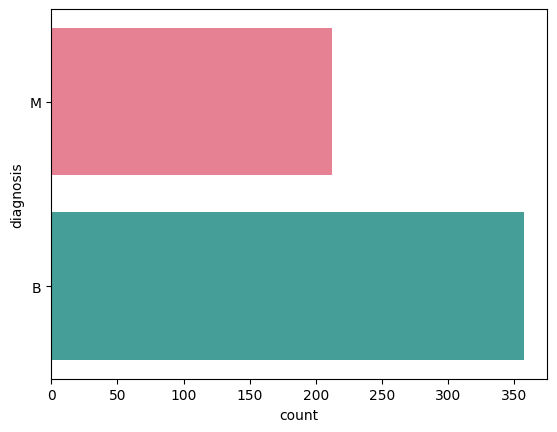

In [ ]:
sns.countplot(df['diagnosis'], palette='husl')

## clean and prepare the data

In [ ]:
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)

In [ ]:
df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [ ]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [ ]:
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [ ]:
df.corr()

diagnosis  radius_mean  texture_mean  perimeter_mean  \
diagnosis                 1.000000     0.730029      0.415185        0.742636   
radius_mean               0.730029     1.000000      0.323782        0.997855   
texture_mean              0.415185     0.323782      1.000000        0.329533   
perimeter_mean            0.742636     0.997855      0.329533        1.000000   
area_mean                 0.708984     0.987357      0.321086        0.986507   
smoothness_mean           0.358560     0.170581     -0.023389        0.207278   
compactness_mean          0.596534     0.506124      0.236702        0.556936   
concavity_mean            0.696360     0.676764      0.302418        0.716136   
concave points_mean       0.776614     0.822529      0.293464        0.850977   
symmetry_mean             0.330499     0.147741      0.071401        0.183027   
fractal_dimension_mean   -0.012838    -0.311631     -0.076437       -0.261477   
radius_se                 0.567134     0.679090      0.275869        0.691765   
texture_se               -0.008303    -0.097317      0.386358       -0.086761   
perimeter_se              0.556141     0.674172      0.281673        0.693135   
area_se                   0.548236     0.735864      0.259845        0.744983   
smoothness_se            -0.067016    -0.222600      0.006614       -0.202694   
compactness_se            0.292999     0.206000      0.191975        0.250744   
concavity_se              0.253730     0.194204      0.143293        0.228082   
concave points_se         0.408042     0.376169      0.163851        0.407217   
symmetry_se              -0.006522    -0.104321      0.009127       -0.081629   
fractal_dimension_se      0.077972    -0.042641      0.054458       -0.005523   
radius_worst              0.776454     0.969539      0.352573        0.969476   
texture_worst             0.456903     0.297008      0.912045        0.303038   
perimeter_worst           0.782914     0.965137      0.358040        0.970387   
area_worst                0.733825     0.941082      0.343546        0.941550   
smoothness_worst          0.421465     0.119616      0.077503        0.150549   
compactness_worst         0.590998     0.413463      0.277830        0.455774   
concavity_worst           0.659610     0.526911      0.301025        0.563879   
concave points_worst      0.793566     0.744214      0.295316        0.771241   
symmetry_worst            0.416294     0.163953      0.105008        0.189115   
fractal_dimension_worst   0.323872     0.007066      0.119205        0.051019   

                         area_mean  smoothness_mean  compactness_mean  \
diagnosis                 0.708984         0.358560          0.596534   
radius_mean               0.987357         0.170581          0.506124   
texture_mean              0.321086        -0.023389          0.236702   
perimeter_mean            0.986507         0.207278          0.556936   
area_mean                 1.000000         0.177028          0.498502   
smoothness_mean           0.177028         1.000000          0.659123   
compactness_mean          0.498502         0.659123          1.000000   
concavity_mean            0.685983         0.521984          0.883121   
concave points_mean       0.823269         0.553695          0.831135   
symmetry_mean             0.151293         0.557775          0.602641   
fractal_dimension_mean   -0.283110         0.584792          0.565369   
radius_se                 0.732562         0.301467          0.497473   
texture_se               -0.066280         0.068406          0.046205   
perimeter_se              0.726628         0.296092          0.548905   
area_se                   0.800086         0.246552          0.455653   
smoothness_se            -0.166777         0.332375          0.135299   
compactness_se            0.212583         0.318943          0.738722   
concavity_se              0.207660         0.248396          0.570517   
concave points_se         0.372320         0.

radius_mean , perimeter _mean, area_mean have a high correlation with malignant tumor

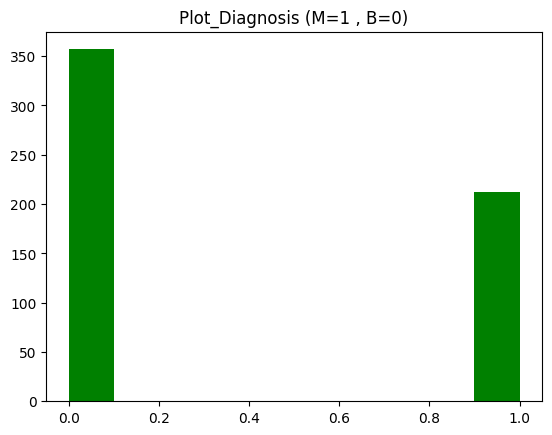

In [ ]:
plt.hist(df['diagnosis'], color='g')
plt.title('Plot_Diagnosis (M=1 , B=0)')
plt.show()

<Axes: >

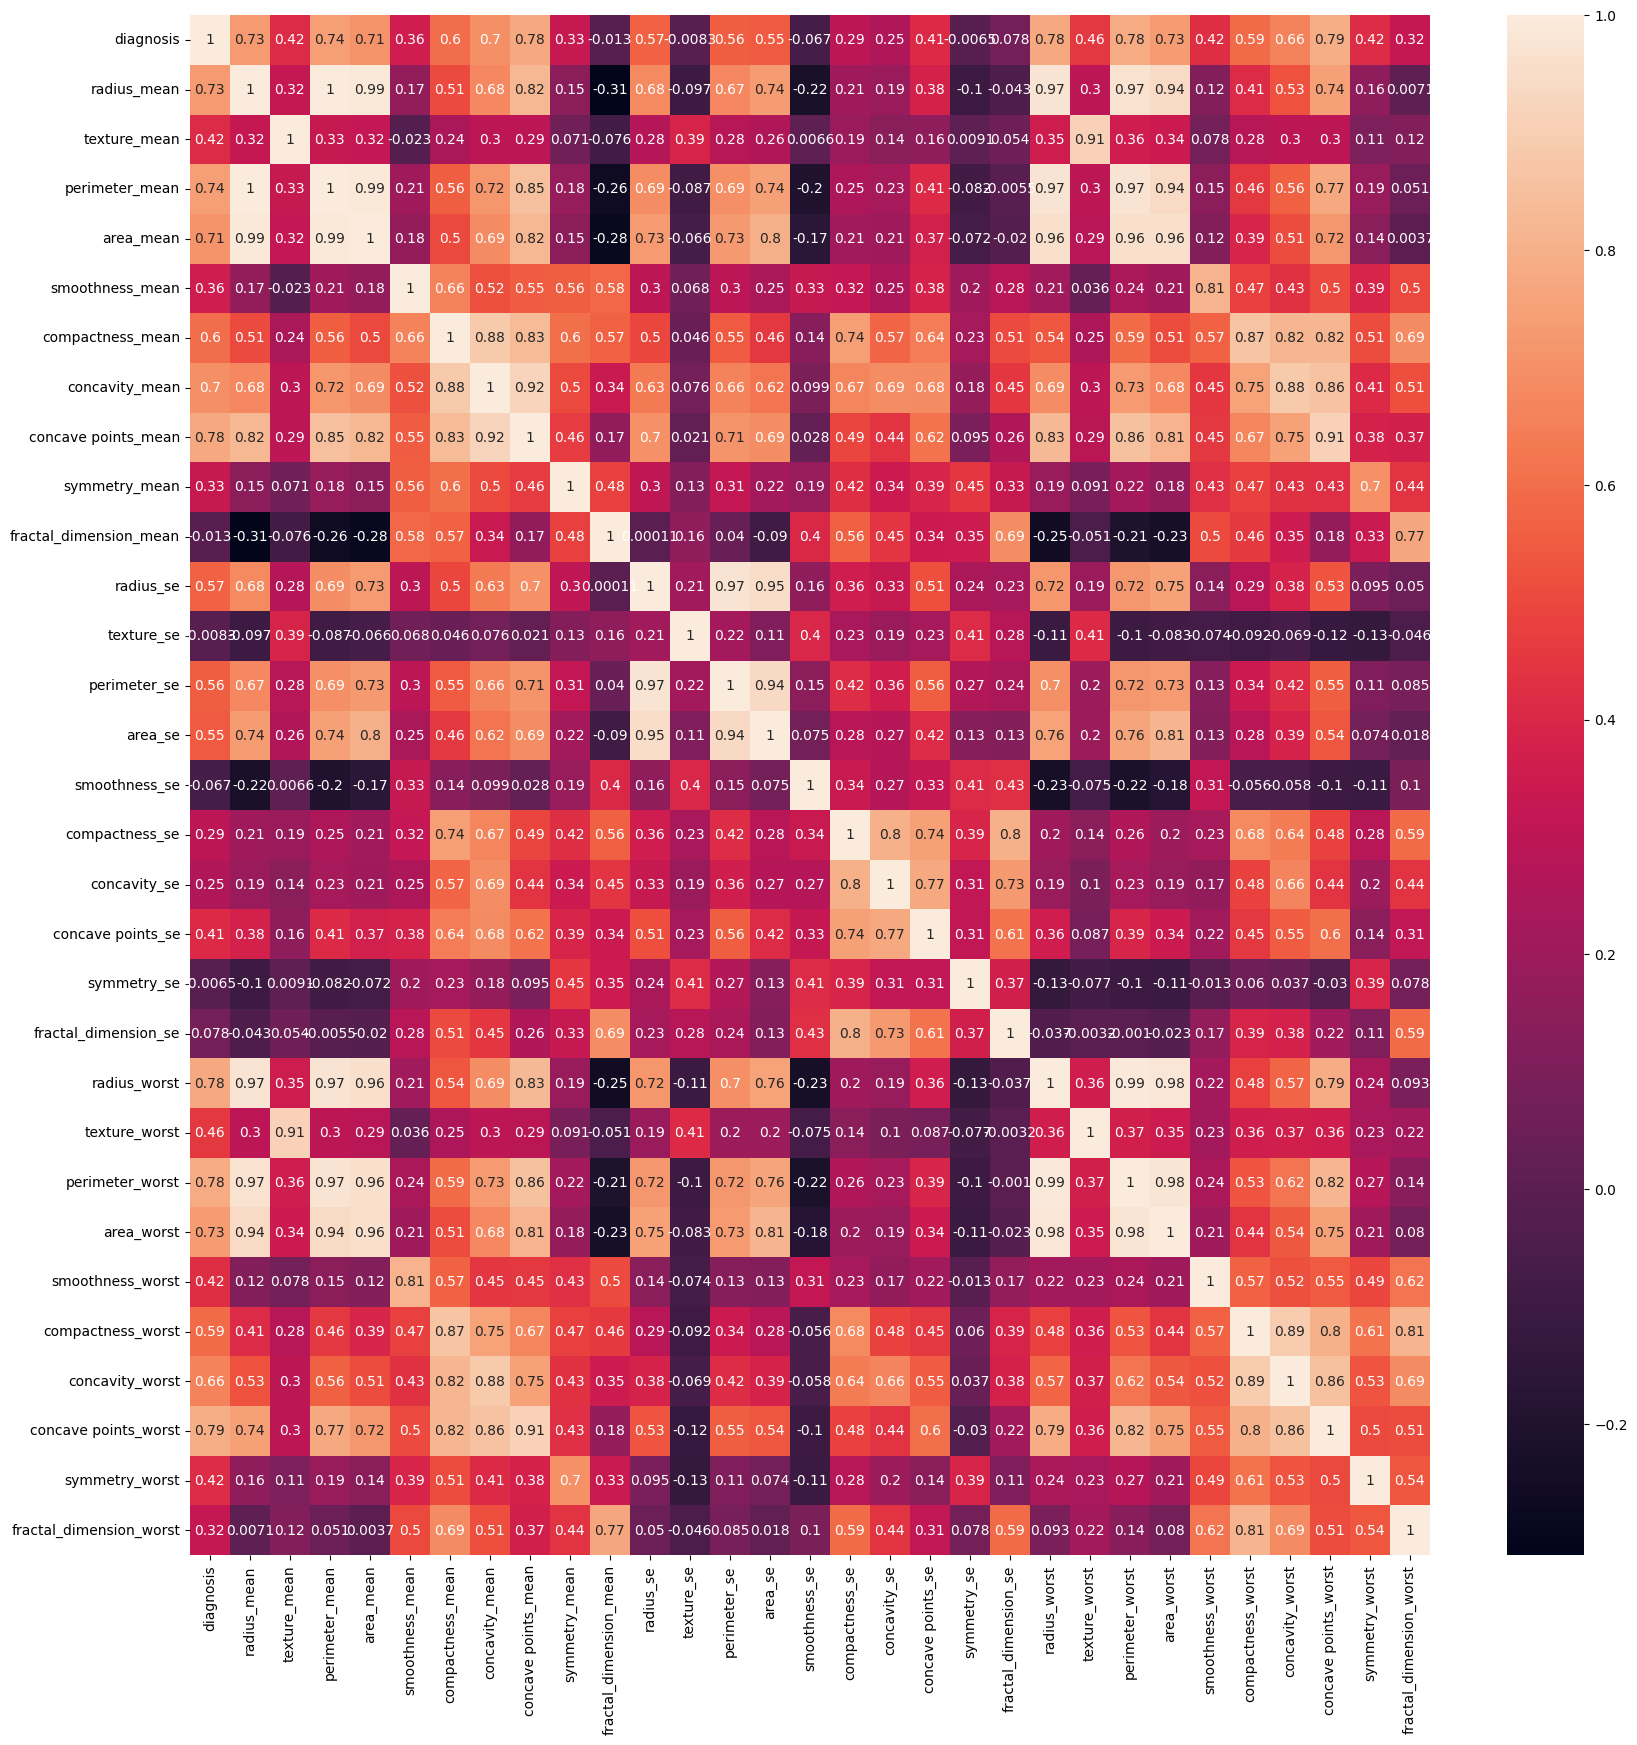

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)

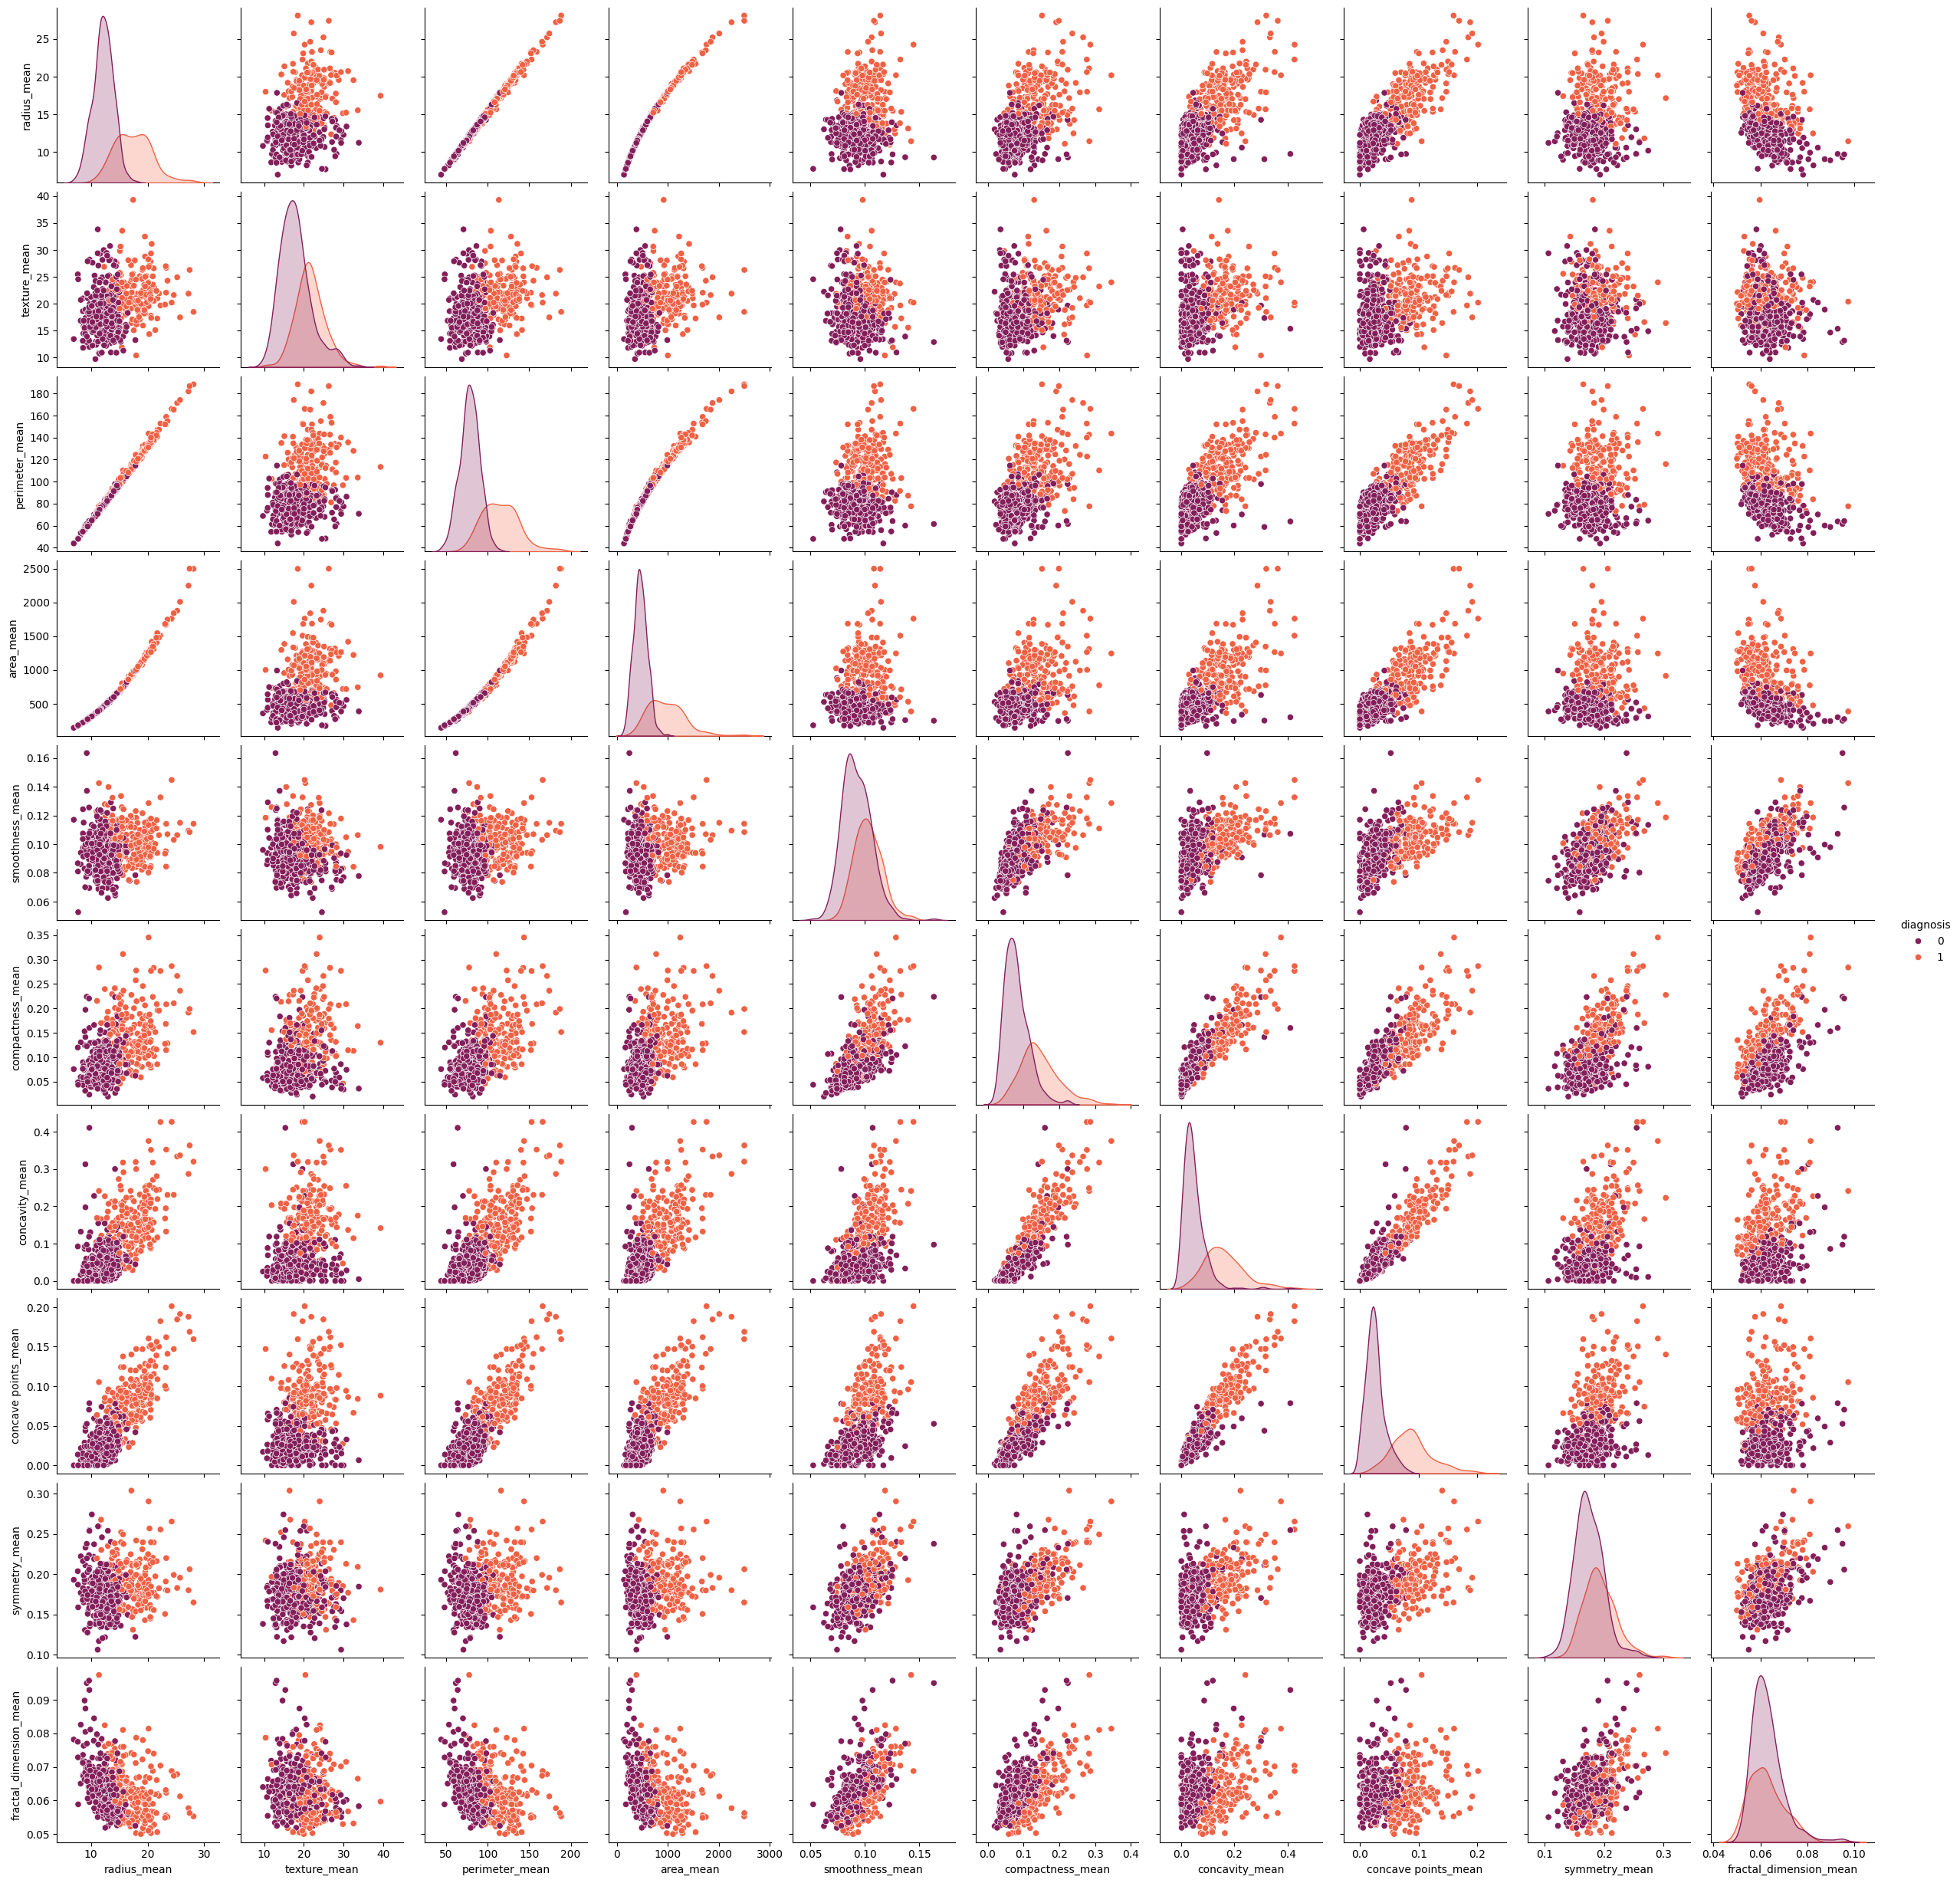

In [ ]:
# generate a scatter plot matrix with the "mean" columns
cols = ['diagnosis',
        'radius_mean',
        'texture_mean',
        'perimeter_mean',
        'area_mean',
        'smoothness_mean',
        'compactness_mean',
        'concavity_mean',
        'concave points_mean',
        'symmetry_mean',
        'fractal_dimension_mean']

sns.pairplot(data=df[cols], hue='diagnosis', palette='rocket')

almost perfectly linear patterns between the radius, perimeter and area attributes are hinting at the presence of multicollinearity between these variables. (they are highly linearly related)
Another set of variables that possibly imply multicollinearity are the concavity, concave_points and compactness.

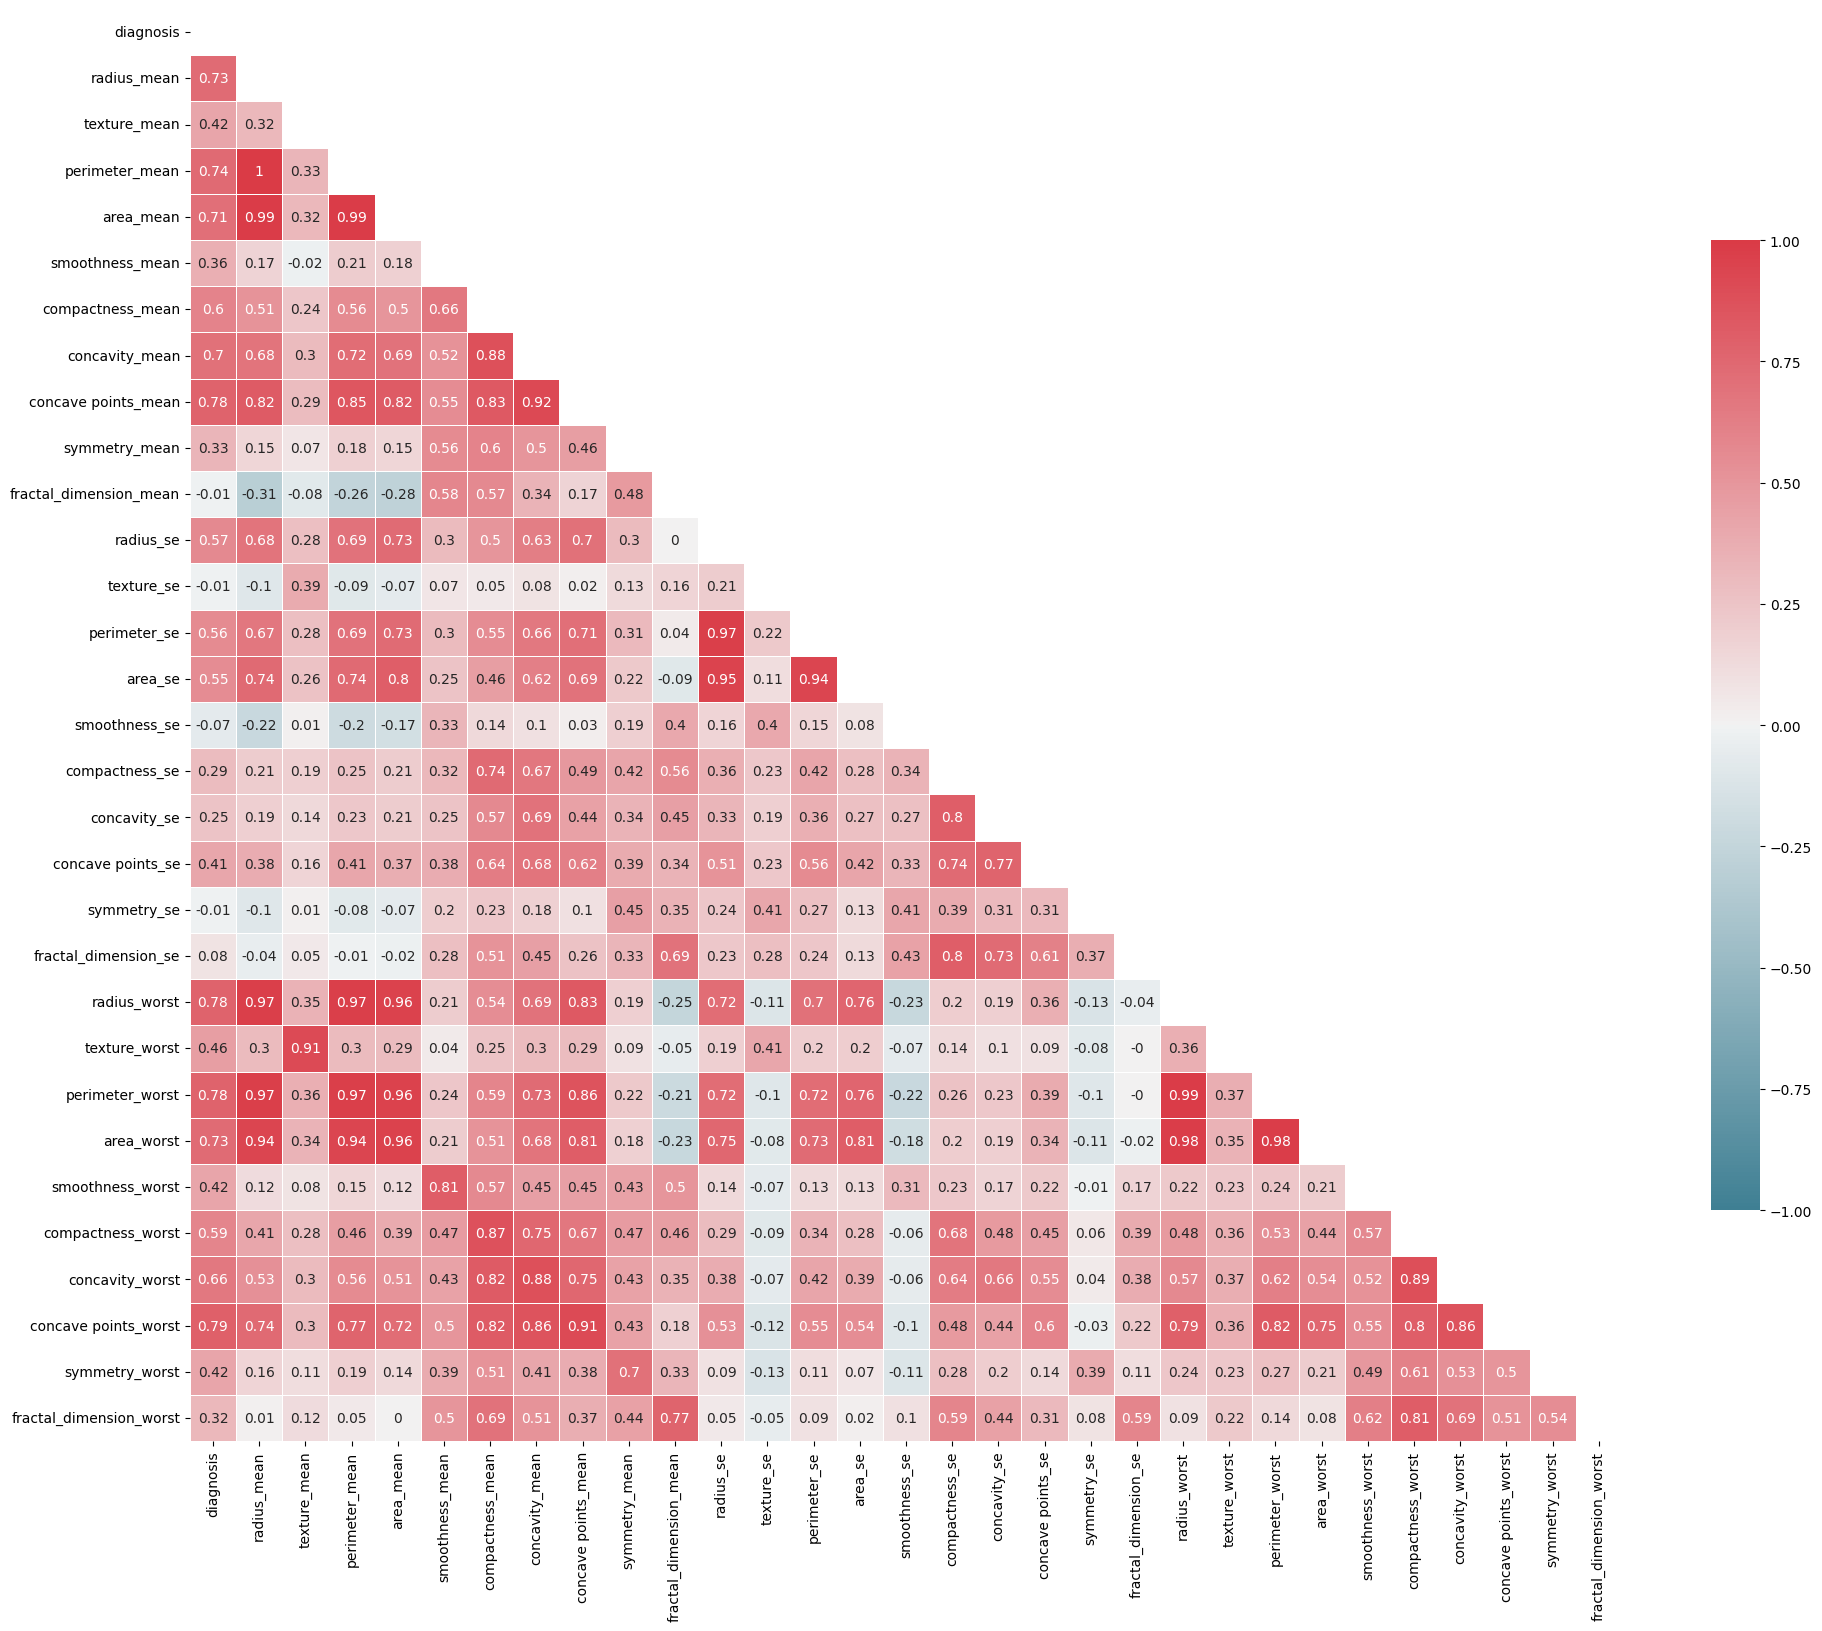

In [ ]:
# Generate and visualize the correlation matrix
corr = df.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool) # Changed np.bool to bool
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

also there is multicollinearity between the attributes compactness, concavity, and concave points. So we can choose just ONE
out of these, I am going for Compactness.

In [ ]:
# first, drop all "worst" columns
cols = ['radius_worst',
        'texture_worst',
        'perimeter_worst',
        'area_worst',
        'smoothness_worst',
        'compactness_worst',
        'concavity_worst',
        'concave points_worst',
        'symmetry_worst',
        'fractal_dimension_worst']
df = df.drop(cols, axis=1)

# then, drop all columns related to the "perimeter" and "area" attributes
cols = ['perimeter_mean',
        'perimeter_se',
        'area_mean',
        'area_se']
df = df.drop(cols, axis=1)

# lastly, drop all columns related to the "concavity" and "concave points" attributes
cols = ['concavity_mean',
        'concavity_se',
        'concave points_mean',
        'concave points_se']
df = df.drop(cols, axis=1)

# verify remaining columns
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se'],
      dtype='object')

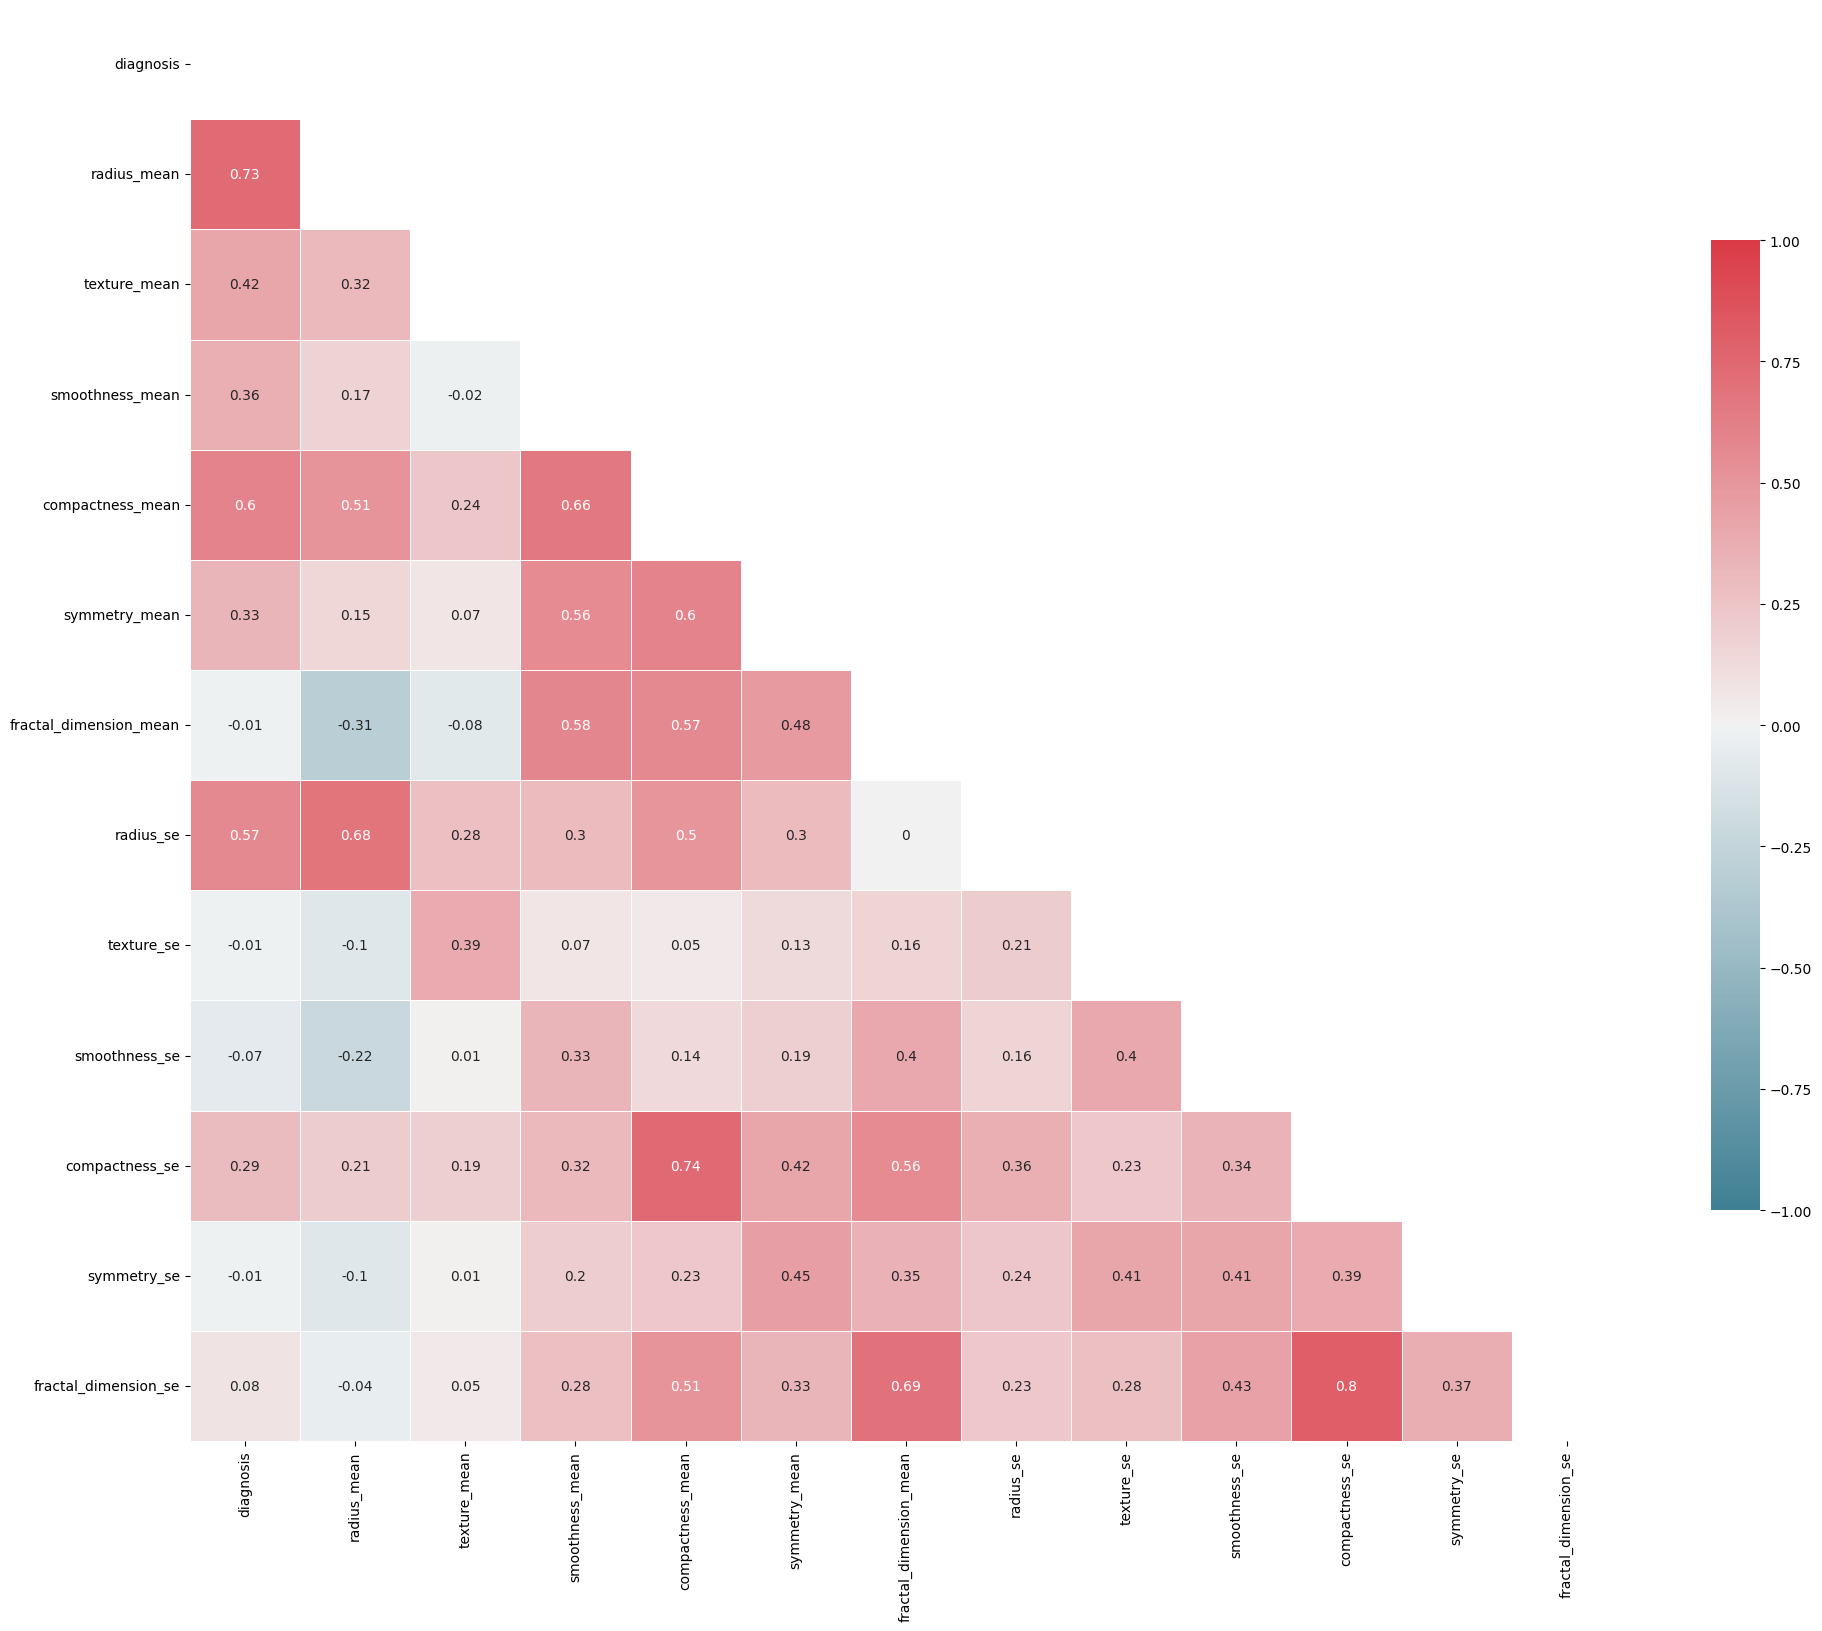

In [ ]:
# Draw the heatmap again, with the new correlation matrix
corr = df.corr().round(2)
mask = np.zeros_like(corr, dtype=bool) # Changed np.bool to bool
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

## Building Model


In [ ]:
X=df.drop(['diagnosis'],axis=1)
y = df['diagnosis']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=40)

### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

X_train=ss.fit_transform(X_train)
X_test=ss.fit_transform(X_test)

### Models and finding out the Best one

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

model1=lr.fit(X_train,y_train)
prediction1=model1.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,prediction1)
cm

array([[110,   5],
       [  2,  54]])

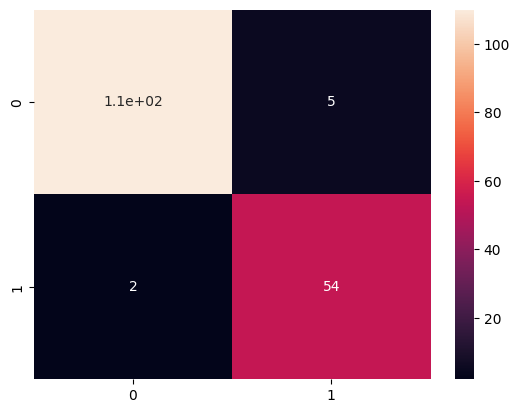

In [ ]:
sns.heatmap(cm,annot=True)
plt.savefig('h.png')

In [ ]:
TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

Testing Accuracy: 0.9590643274853801


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test,prediction1)

0.9590643274853801

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc=DecisionTreeClassifier()
model2=dtc.fit(X_train,y_train)
prediction2=model2.predict(X_test)
cm2= confusion_matrix(y_test,prediction2)

In [ ]:
cm2

array([[107,   8],
       [  6,  50]])

In [ ]:
accuracy_score(y_test,prediction2)

0.9181286549707602

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()
model3 = rfc.fit(X_train, y_train)
prediction3 = model3.predict(X_test)
confusion_matrix(y_test, prediction3)

array([[108,   7],
       [  5,  51]])

In [ ]:
accuracy_score(y_test, prediction3)

0.9298245614035088

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction3))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       115
           1       0.88      0.91      0.89        56

    accuracy                           0.93       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.93      0.93       171



In [ ]:
print(classification_report(y_test, prediction1))

print(classification_report(y_test, prediction2))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       115
           1       0.92      0.96      0.94        56

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.96      0.96      0.96       171

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       115
           1       0.86      0.89      0.88        56

    accuracy                           0.92       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.92      0.92       171



#### K Nearest Neighbor (K NN)
#### Support Vector Machine
#### Naive Bayes

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
models=[]

models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
# evaluate each model

results =[]
names=[]
for name , model in models:
    kfold=KFold(n_splits=10, random_state=40, shuffle=True) # Added shuffle=True to the KFold constructor
    cv_results= cross_val_score(model, X_train, y_train, cv=kfold,scoring='accuracy')
    results.append(cv_results)
    names.append(name)

    msg= '%s:, %f, (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN:, 0.901987, (0.044061)
NB:, 0.899744, (0.064079)
SVM:, 0.909615, (0.045167)


In [ ]:
# make predictions on test datasets

SVM = SVC()
SVM.fit(X_train, y_train)
predictions= SVM.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.9649122807017544
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       115
           1       0.95      0.95      0.95        56

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171

[[112   3]
 [  3  53]]


##### We are getting the best accuracy with SVM which is 96.4%  , the model is predicting with 96% accuracy on our test data
